In [15]:
import scanpy as sc
import os
import sys
import pandas as pd
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from muon import atac as ac
import scipy.sparse

In [2]:
sys.path.append(os.path.expanduser('~/atac_data/misc_scripts/'))
from map_peaks_to_genes import gtf_to_pybedtools, make_bed
import helper_funcs

In [3]:
%cd pbmc_10x/

/home/danted/atac_data/pbmc_10x


In [4]:
atac = sc.read_h5ad("pbmc_10x_atac_preprocess.h5ad")

In [5]:
atac.var['variance'] = np.var(atac.X.toarray(), axis=0) #may take several minutes due to size of dense array

Let's look at the mean-variance relationship of the peak counts

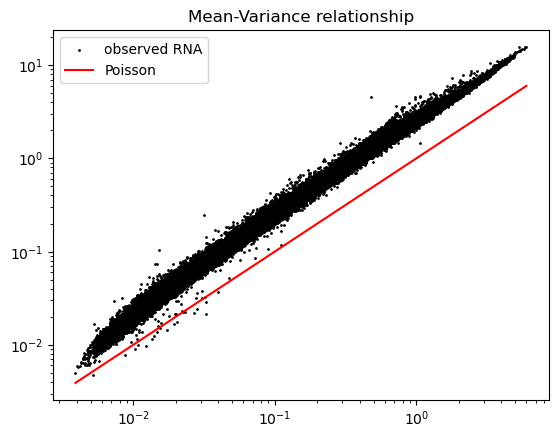

In [6]:
helper_funcs.mean_var_curvefit(atac, atac.var.mean_counts, atac.var.variance)

In [28]:
peaks = pd.read_csv(StringIO(make_bed(atac)), sep='\t', header=None).iloc[:, :3]

In [29]:
peaks.columns = ['Chromosome', 'Start', 'End']

In [ ]:
fragment_matrix = helper_funcs.make_fragment_matrix(atac, peaks, "atac_v2_pbmc_10k_fragments.tsv.gz") #create the fragment matrix

processing peak 0
processing peak 1
processing peak 2
processing peak 3
processing peak 4
processing peak 5
processing peak 6
processing peak 7
processing peak 8
processing peak 9
processing peak 10
processing peak 11
processing peak 12
processing peak 13
processing peak 14
processing peak 15
processing peak 16
processing peak 17
processing peak 18
processing peak 19
processing peak 20
processing peak 21
processing peak 22
processing peak 23
processing peak 24
processing peak 25
processing peak 26
processing peak 27
processing peak 28
processing peak 29
processing peak 30
processing peak 31
processing peak 32
processing peak 33
processing peak 34
processing peak 35
processing peak 36
processing peak 37
processing peak 38
processing peak 39
processing peak 40
processing peak 41
processing peak 42
processing peak 43
processing peak 44
processing peak 45
processing peak 46
processing peak 47
processing peak 48
processing peak 49
processing peak 50
processing peak 51
processing peak 52
pro

In [ ]:
scipy.sparse.save_npz("fragment_matrix.npz", fragment_matrix) #save the fragment matrix to a compressed sparse matrix format

In [8]:
fragment_matrix = scipy.sparse.load_npz("fragment_matrix.npz")

In [9]:
fragment_matrix

<9583x165088 sparse matrix of type '<class 'numpy.float32'>'
	with 112837836 stored elements in Compressed Sparse Row format>

In [10]:
atac.layers['fragments'] = fragment_matrix.copy()

In [11]:
atac.var['fragments_mean'] = np.mean(atac.layers['fragments'].toarray(), axis=0) #calculate the mean of the fragment matrix

In [12]:
atac.var['fragments_variance'] = np.var(atac.layers['fragments'].toarray(), axis=0) #calculate the variance of the fragment matrix

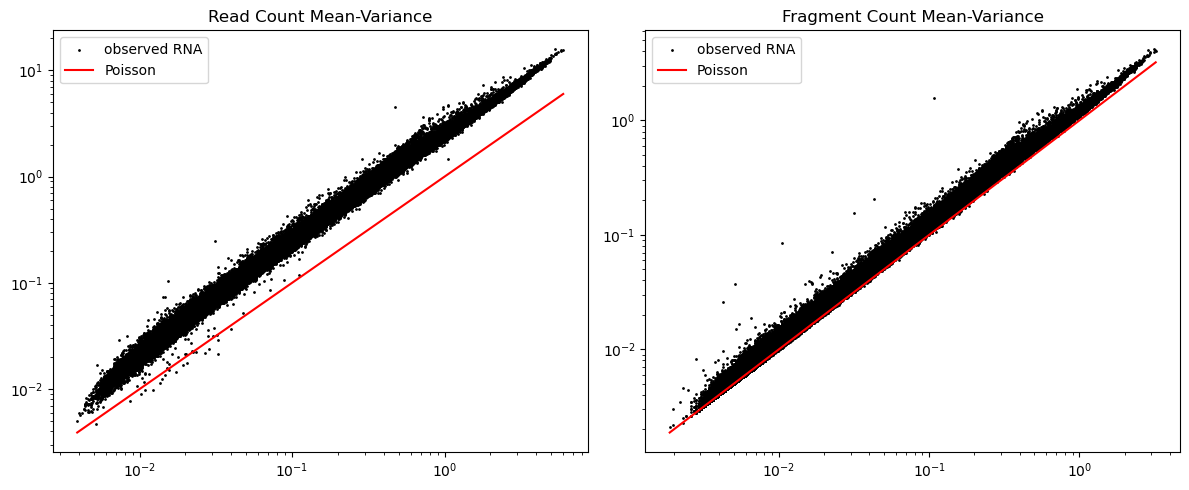

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Example: two different mu/var pairs
helper_funcs.mean_var_curvefit(atac,atac.var.mean_counts, atac.var.variance, ax=axes[0], title='Read Count Mean-Variance')
helper_funcs.mean_var_curvefit(atac,atac.var.fragments_mean, atac.var.fragments_variance, ax=axes[1], title='Fragment Count Mean-Variance')

plt.tight_layout()
plt.show()

In [18]:
df = helper_funcs.residual_vars(atac, theta=np.inf, layer='fragments') #poisson

Processing peaks 0 to 9999
Processing peaks 10000 to 19999
Processing peaks 20000 to 29999
Processing peaks 30000 to 39999
Processing peaks 40000 to 49999
Processing peaks 50000 to 59999
Processing peaks 60000 to 69999
Processing peaks 70000 to 79999
Processing peaks 80000 to 89999
Processing peaks 90000 to 99999
Processing peaks 100000 to 109999
Processing peaks 110000 to 119999
Processing peaks 120000 to 129999
Processing peaks 130000 to 139999
Processing peaks 140000 to 149999
Processing peaks 150000 to 159999
Processing peaks 160000 to 165087


In [19]:
hvgs = df.residual_variance.sort_values(ascending=False)[:1000].index

In [20]:
atac.var['highly_variable'] = atac.var.index.isin(hvgs).copy()

In [21]:
atac.var['residual_variance'] = df.residual_variance.copy()

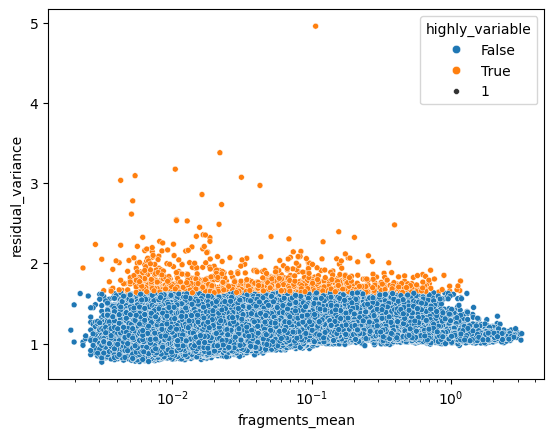

In [22]:
sns.scatterplot(x=atac.var.fragments_mean, y=atac.var.residual_variance, hue=atac.var.highly_variable, size=1)
plt.xscale('log')
plt.show()

Since we have effectively modeled counts via a poisson model, we can log normalize counts in a similar manner to scRNA-seq data, but it is noted that other methods such as TF-IDF can be used as shown in this [publication](https://www.science.org/doi/10.1126/science.aab1601)

In [23]:
atac.layers['raw'] = atac.X.copy()
atac.X = atac.layers['fragments'].copy()
sc.pp.normalize_total(atac, target_sum=1e4)
sc.pp.log1p(atac)

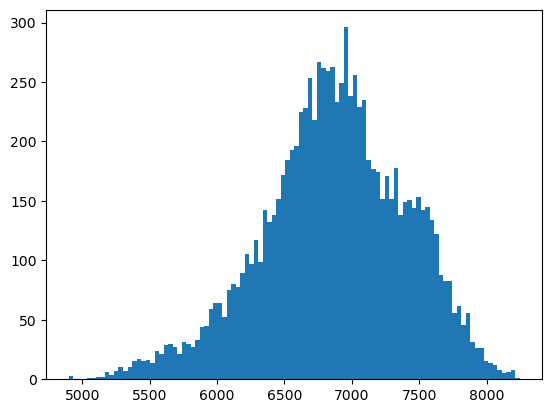

In [24]:
plt.hist(atac.X.sum(axis=1), bins=100)
plt.show()

Above we can see the data looks fairly normally distributed after normalization

We can now proceed with dimensionaly reduction based on peaks data

In [25]:
sc.tl.pca(atac, svd_solver='arpack', use_highly_variable=True)
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=30)
sc.tl.leiden(atac, resolution=0.8)
sc.tl.umap(atac, random_state=0, min_dist=.3)

/home/danted/miniforge3/envs/atac/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/tmp/ipykernel_16792/2349604747.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(atac, resolution=0.8)


Below we can see some nice separation in clusters with little technical variation in sequencing depth

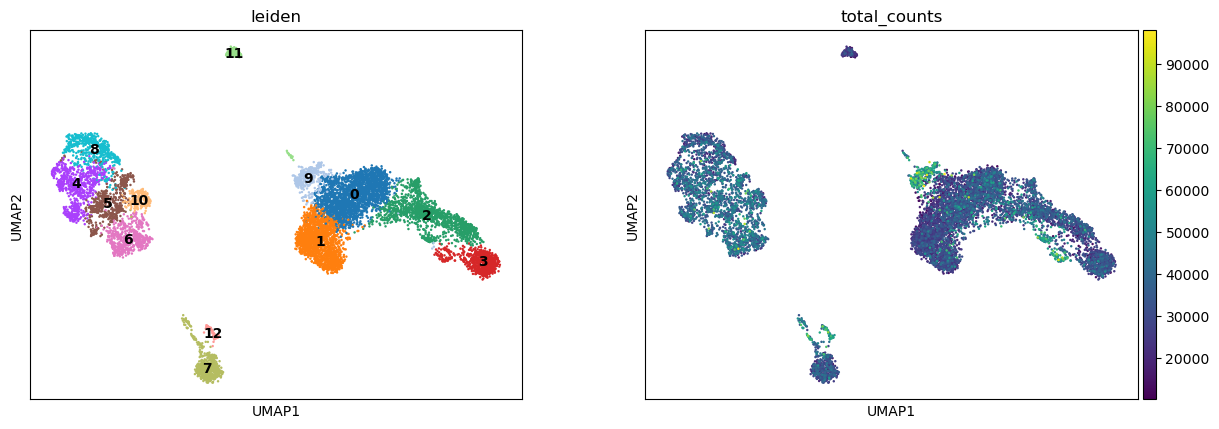

In [26]:
sc.pl.umap(atac, color=["leiden","total_counts"], legend_loc="on data")

## Gene Activty Matrix 

While we could proceed with analyzing the data above, it can be sometimes diffcult to interpret genomic coordinates without known canonical genomic functions

Additionally, newer multiomic approaches want to combine both genomic and transcriptomic data for greater biological interpretation. So, we can quanity the "activity" of each gene by counting the fragments associated with a gene by summing the fragments that overlap gene bodies and promoter regions.

Belowe we are going to create a gene activity matrix to better understand how these fragment counts overlap with genes in a similar manner to the [Signac](https://stuartlab.org/signac/articles/pbmc_vignette.html) R package

In [30]:
tmp = gtf_to_pybedtools(gtf=os.path.expanduser("~/atac_data/refdata-gex-GRCh38-2020-A/genes/genes.gtf"), feature='gene', saveas=True, ondisk=False, chromosomes=peaks.Chromosome.unique().tolist())

Let's create a dataframe with genomic coordinates of gene bodies

In [31]:
# Define the 'features' DataFrame with the specified columns if it's not already defined
features = pd.DataFrame(columns=['Chromosome', 'Start', 'End', 'gene_name'])

rows = []  # Initialize an empty list to collect rows

for i in tmp:
    chrom, start, end, strand, gene_name = i.chrom, i.start, i.end, i.strand, i.name
    rows.append([chrom, start, end, strand, gene_name])  # Append the row to the list

# Convert the list of rows into a DataFrame and append it to the existing 'features' DataFrame
tmp_df = pd.DataFrame(rows, columns=['Chromosome', 'Start', 'End', 'Strand', 'gene_name'])

tmp_df.set_index('gene_name', inplace=True, drop=True)

tmp_df.index.name = ''

In [32]:
tmp_df

Chromosome     Start       End Strand
                                            
OR4F5        chr1     65418     71585      +
OR4F29       chr1    450702    451697      -
OR4F16       chr1    685678    686673      -
SAMD11       chr1    923927    944581      +
NOC2L        chr1    944202    959309      -
...           ...       ...       ...    ...
BPY2B        chrY  24607559  24639207      +
DAZ3         chrY  24763068  24813492      -
DAZ4         chrY  24833842  24907040      +
BPY2C        chrY  25030900  25062548      -
CDY1         chrY  25622161  25624902      +

[19352 rows x 4 columns]

We can now leverage the muon package to create a gene activity matrix

In [ ]:
ga = ac.tl.count_fragments_features(atac, features=tmp_df, stranded=True)

100%|██████████| 19352/19352 [14:44<00:00, 21.88it/s] 
/home/danted/miniforge3/envs/atac/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [34]:
ga.X = ga.X.astype(np.float32)

In [35]:
ga.var_names_make_unique()

In [60]:
sc.pp.normalize_total(ga, target_sum=1e4)

In [61]:
sc.pp.log1p(ga)

In [62]:
ga.obsp = atac.obsp.copy()
ga.obsm = atac.obsm.copy()
ga.uns = atac.uns.copy()

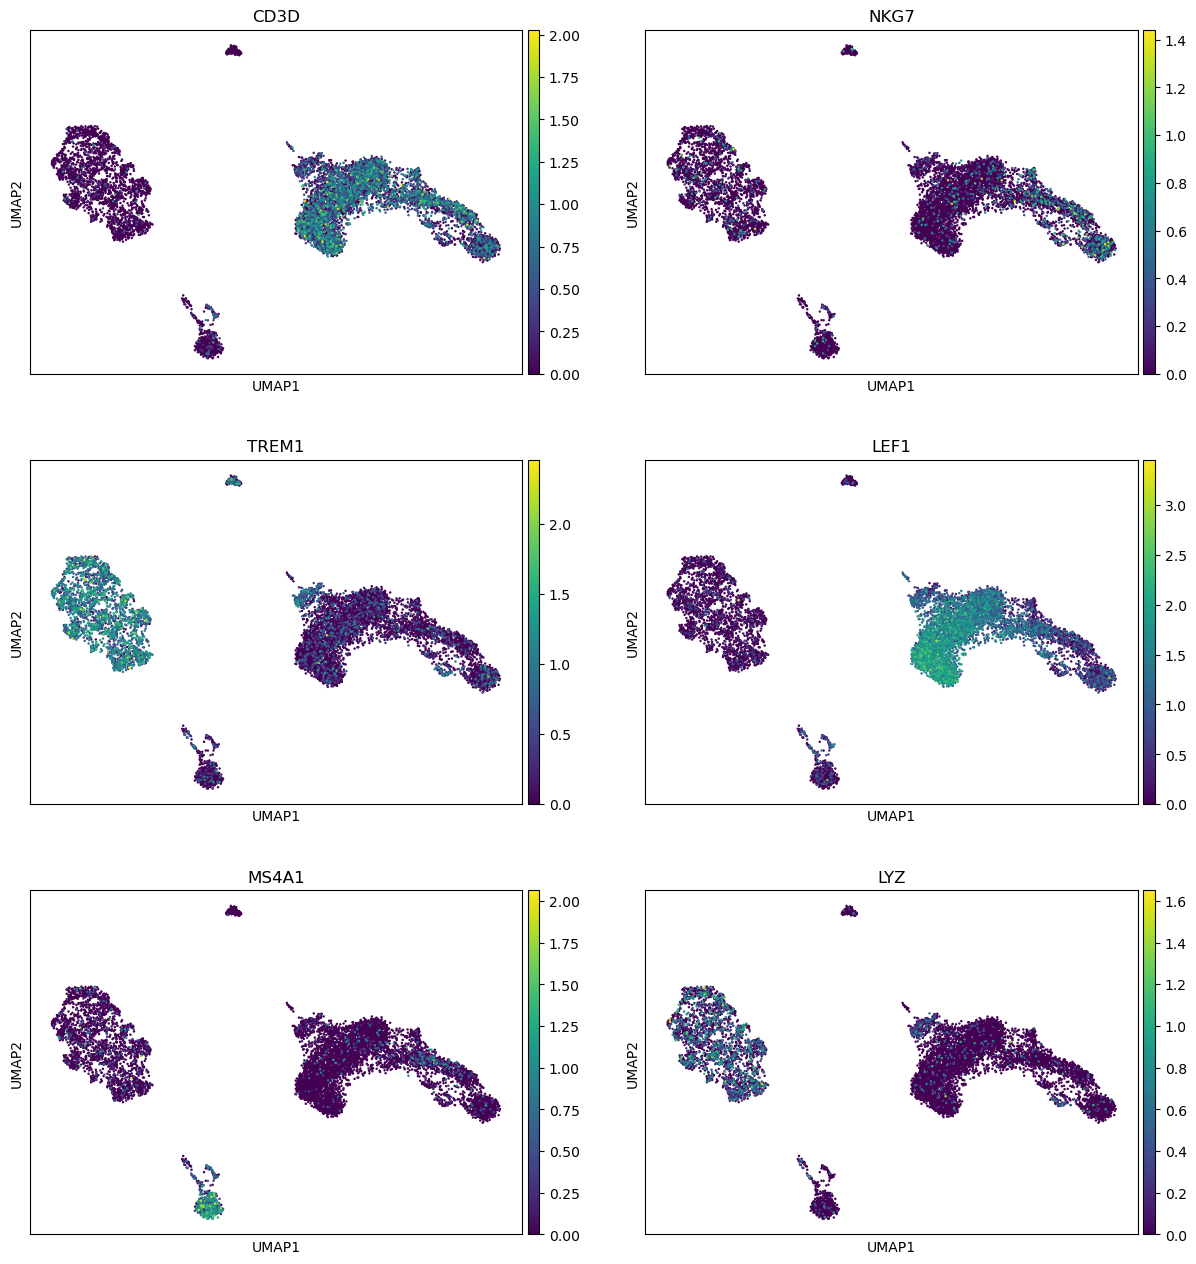

In [63]:
sc.pl.umap(adata=ga, color=["CD3D","NKG7","TREM1","LEF1","MS4A1","LYZ"], legend_loc="on data", ncols=2)

Excellent! Above we can see that the gene activity matrix correlates well with separation of clusters of canonical immune markers.

If we had a matched scRNA-seq dataset from this same donor, we could integrate the two modalities and perform label transfer.

In [64]:
atac.write("pbmc_10x_atac_postprocess.h5ad")